# Libraries

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import itertools
import warnings
from datetime import datetime
from ipywidgets import interactive
import ipywidgets as widgets

# Loading sklearn functionality from prior lessons
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Important functionality for this lesson
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

#Statistical tools for model building etc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
warnings.filterwarnings('ignore')
#import plotly.io as pio
#pio.renderers.default = "notebook_connected"  # for Jupyter
#pio.renderers.default = "png"  # forces static image output
#import kaleido

In [2]:
# Global plotting parameters
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams["axes.grid"] = True

# Brand colors dictionary
brand_colors = {
    "Denim": "#1358DB",
    "Supernova": "#FFCF00",
    # "Black": "#000000",
    # "Dark Blue": "#101D42",
    # "White": "#FFFFFF",
    "Dark Gray": "#6F6F6F",
    # "Light Gray 1": "#F6F6F4",
    "Light Gray 2": "#ADBDCC"
}

# Create a matplotlib colormap
brand_cmap = plt.cm.colors.ListedColormap(list(brand_colors.values()))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=brand_colors.values())

"""
Note: Suppressing warnings is generally not recommended. 
Warnings are being ignored in this notebook to prevent unnecessary clutter
and improve readability while working through the lesson
"""
filterwarnings(action='ignore')

In [3]:
# Functions

def lag_scatterplot(df, column, lag):
    """
    Plots a scatterplot to visualize the relationship between a series and its lagged values
    over a specified time lag.

    Inputs
    --------------
    df: a pandas DataFrame containing the time series data.
    column: a string with the name of the column to be plotted.
    lag: an integer representing the lag in time steps by which the time series values are shifted.

    Outputs
    --------------
    Displays a scatterplot showing the relationship between time series values and their
    lagged values, with the calculated correlation coefficient shown in the plot title.
    """

    # calculating lag
    lagged_values = df[column].shift(lag)

    # calculating correlation
    correlation = df[column].corr(lagged_values).round(3)

    # plotting
    plt.figure()
    plt.scatter(df[column], lagged_values, alpha=0.1, s=40, color='darkblue', edgecolors='darkblue', linewidths=1.5)
    plt.title(f'Correlation: {correlation}')
    plt.ylabel(f'Monthly CO2 Levels (t+{lag})')
    plt.xlabel('Monthly CO2 Levels (t)')
    plt.show()

# Train/Test Split

In order to properly evaluate our models, we need to isolate our Train and Test set. In traditional machine learning  modeling, we generally take random samples of data points and have them randomly assigned to the corresponding sets. **This is not possible in Time Series because there is an order to time that we need to preserve**. In order to keep the sequential order of our data, we generally take a proportion of the most recent data points, and assign them to the Test set. We use the remainder points as our Train set.

First lets start by loading our data, we will use the daily average sampled data that we created in the previous notebook for preprocessing

In [4]:

power_df_monthly = pd.read_csv(r"C:\Users\karni\OneDrive\Desktop\GitHub\BrainStation_CapstoneProject\data\power_weather_monthly.csv",index_col='DateTime')

power_df_monthly.head()

,Energy Consumed by Household (Watt-hour),"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,,
2006-12-01,31.688252,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,25.767232,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,23.351392,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,21.977117,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,14.853149,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [5]:
power_df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 2006-12-01 to 2010-11-01
Data columns (total 20 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Energy Consumed by Household (Watt-hour)                                     48 non-null     float64
 1   Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)  48 non-null     float64
 2   Reactive Energy Consumed by Household (Watt-hour)                            48 non-null     float64
 3   Voltage (volts)                                                              48 non-null     float64
 4   Global_intensity (amperes)                                                   48 non-null     float64
 5   Sub_metering_1 (watt-hours of active energy)                                 48 non-null     float64
 6   Sub_metering_2 (watt-hours of ac

In [6]:
# Time Series Split (test set = most recent 25% of data)

# finding the row number equivalent to 75% of the data
cutoff = int(len(power_df_monthly) * 0.75)
cutoff_date = power_df_monthly.index.sort_values()[cutoff]
print(f"Cutoff at: {cutoff_date}")

# extract train and test indices
dates_train = power_df_monthly.index[power_df_monthly.index <= cutoff_date]
date_train = pd.to_datetime(dates_train) # changing to time stamp
dates_test = power_df_monthly.index[power_df_monthly.index > cutoff_date]
date_test = pd.to_datetime(dates_test) # changing to time stamp

# extract dimensions
print(f"Training Set: {len(dates_train)} days")
print(f"Test Set: {len(dates_test)} days")

Cutoff at: 2009-12-01
Training Set: 37 days
Test Set: 11 days


In [7]:
# Extracting the target variable Energy Consumed by Household (Watt-hour)
y_train = power_df_monthly['Energy Consumed by Household (Watt-hour)'].loc[dates_train]
y_test = power_df_monthly['Energy Consumed by Household (Watt-hour)'].loc[dates_test]

# <a id='toc5_'></a>Forecasting with Regression: Baseline Models [&#8593;](#toc0_)



In this section we will build 2 different models, starting from a naive simple average model, to a multiple linear regression model.

At every iteration we will fit the model, visualize it against the original data and evaluate the predictions. We will not apply any regularization for now, we will use Lasso, Ridge, in Sprint 3 for of regression model.


Here is an overview of the models that I  will build:

1. **Average Model:** $y = mean(y)$
  
2. **Linear Model with One Feature:** $y = \beta_0 + \beta_1\text{DaysFromStart}$

3. **Linear Model with Dummy Variables:** $y = \beta_0 + \beta_1\text{DaysFromStart} + \beta_2\text{January} + \beta_3\text{February} + .... + \beta_{13}\text{December}$



As we go through the model building process we will use the following table to keep track of our model performance metrics:

## Initialize a dataframe for storing results


In [8]:
summary_df = pd.DataFrame(columns=["Train_MAE", "Test_MAE", "Train_MAPE", "Test_MAPE"])

## Mean Model

We will start with a  model of simply guessing the mean of the data. We do not expect this to perform well, however it serves as a good starting point to extract some baseline evaluation metrics that we will try to improve further down.

In [9]:
# Predict

train_mean = y_train.mean()

training_size = len(dates_train)
test_size = len(dates_test)

mean_pred_train = np.full((training_size, 1), train_mean)
mean_pred_test = np.full((test_size, 1), train_mean) 

In [10]:
# Drop NaNs from target and predictions for fair comparison
train_mask = ~y_train.isna()
test_mask = ~y_test.isna()

summary_df.loc['Mean'] = [
    mean_absolute_error(
        y_train[train_mask],
        mean_pred_train.flatten()[train_mask.values]
    ),
    mean_absolute_error(
        y_test[test_mask],
        mean_pred_test.flatten()[test_mask.values]
    ),
    mean_absolute_percentage_error(
        y_train[train_mask],
        mean_pred_train.flatten()[train_mask.values]
    ),
    mean_absolute_percentage_error(
        y_test[test_mask],
        mean_pred_test.flatten()[test_mask.values]
    )
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347,3.101882,0.292217,0.215832


In [11]:
import plotly.graph_objs as go

fig = go.Figure()

# Original time series
fig.add_trace(go.Scatter(
    x=power_df_monthly.index,
    y=power_df_monthly['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=mean_pred_train.flatten(),
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=mean_pred_test.flatten(),
    mode='lines',
    name='test',
    line=dict(color='green', dash='dash')
))

# Set x-axis ticks for better readability
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
fig.update_layout(
    title='Average Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=power_df_monthly.index[::step],
        ticktext=labels[::step],
        tickangle=45
    ),
    width=900,
    height=400
)

#fig.show()

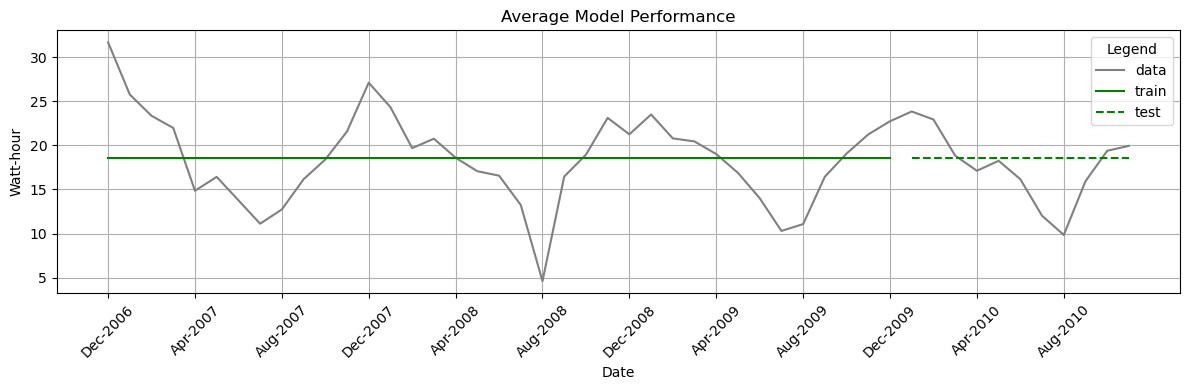

In [12]:
plt.figure()

# Original time series
plt.plot(power_df_monthly.index, power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label='data')

# Train predictions
plt.plot(dates_train, mean_pred_train.flatten(), color='green', label='train')

# Test predictions
plt.plot(dates_test, mean_pred_test.flatten(), color='green', linestyle='--', label='test')

plt.title('Average Model Performance')
plt.ylabel('Watt-hour')
plt.xlabel('Date')
plt.legend(title='Legend')

# Format x-axis as month-year and reduce number of ticks
locs = plt.gca().get_xticks()
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
plt.xticks(ticks=range(0, len(labels), step), labels=labels[::step], rotation=45)

plt.tight_layout()
plt.show()


## Linear Regression Model with one Feature

In [13]:
first_day = power_df_monthly.index.min() # We get a string here
first_day = pd.to_datetime(first_day) # cahnging to time stamp
print(first_day)

2006-12-01 00:00:00


In [14]:
# Feature Engineering

# Ensure first_day is a Timestamp
first_day = pd.to_datetime(power_df_monthly.index.min())

# Ensure dates_train and dates_test are DatetimeIndex
#dates_train_dt = pd.to_datetime(dates_train)
#dates_test_dt = pd.to_datetime(dates_test)

# Create a numerical X feature that encodes the days from the start of the data
X_train = pd.DataFrame({"days_from_start": (dates_train_dt - first_day).days}, index=dates_train)
X_test = pd.DataFrame({"days_from_start": (dates_test_dt - first_day).days}, index=dates_test)

X_train.head()

NameError: name 'dates_train_dt' is not defined

In [ ]:
first_day

In [ ]:
y_train

In [ ]:
# Fit
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict
linreg_pred_train = linreg.predict(X_train)
linreg_pred_test = linreg.predict(X_test)

In [ ]:
# Evaluate

summary_df.loc['linreg'] = [
    mean_absolute_error(y_train, linreg_pred_train),
    mean_absolute_error(y_test, linreg_pred_test),
    mean_absolute_percentage_error(y_train, linreg_pred_train),
    mean_absolute_percentage_error(y_test, linreg_pred_test)
]

summary_df

In [ ]:
plt.figure(figsize=(12, 4))

# Original time series
plt.plot(power_df_monthly.index, power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label='data')

# Train predictions
plt.plot(dates_train, linreg_pred_train, color='green', label='train')

# Test predictions
plt.plot(dates_test, linreg_pred_test, color='green', linestyle='--', label='test')

plt.title('Linear Regression Model Performance')
plt.ylabel('Watt-hour')
plt.xlabel('Date')
plt.legend(title='Legend')

# Format x-axis as month-year and reduce number of ticks
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
plt.xticks(ticks=range(0, len(labels), step), labels=labels[::step], rotation=45)

plt.tight_layout()
plt.show()


This looks slightly better  in  our visual intuition.  As you might expect, our model captures the overal trend of the data as a straight line with an downward slope.  Our evaluation metrics indicate that our model has an overall error of 4.07	Watt-hour on average (MAE) for training data, but a lower error rate of 3.33 Watt-hour for test data.  

__Note__: Notice how the errors are significantly lower for the test data than for train.  Normally, we think of this phenomenon as a consequence of underfittting, but here we see that our train data are systematically higher than our predictions.  Thus, there is some sort of trend in the data that we are not capturing. This is where we can perform additional feature engineering to further improve how we model the trend in our data.


## <a id='toc5_2_'></a>Linear Regression with One-Hot Encoding Feature [&#8593;](#toc0_)

In [ ]:
# Feature Engineering

# instantiate encoder
ohe = OneHotEncoder(sparse_output=False, dtype=int)

# extract month names from index
months_train = dates_train.month_name().values.reshape(-1, 1)
months_test = dates_test.month_name().values.reshape(-1, 1)

# fit on train set, transform train and test
ohe_months_train = ohe.fit_transform(months_train)
ohe_months_test = ohe.transform(months_test)

# convert data back into a dataframe
ohe_train_df = pd.DataFrame(ohe_months_train, columns=ohe.get_feature_names_out(), index=dates_train)
ohe_test_df = pd.DataFrame(ohe_months_test, columns=ohe.get_feature_names_out(), index=dates_test)

# Use days_from_start as before
first_day = pd.to_datetime(power_df_monthly.index.min())
X_train_days = pd.DataFrame({"days_from_start": (pd.to_datetime(dates_train) - first_day).days}, index=dates_train)
X_test_days = pd.DataFrame({"days_from_start": (pd.to_datetime(dates_test) - first_day).days}, index=dates_test)

# concatenate days_from_start and month dummies
X_train_ohe = pd.concat([X_train_days, ohe_train_df], axis=1)
X_test_ohe = pd.concat([X_test_days, ohe_test_df], axis=1)

AttributeError: 'Index' object has no attribute 'month_name'

In [ ]:
X_train_ohe.head()

In [ ]:
X_train_ohe.shape

In [ ]:
# Fit
linreg_ohe = LinearRegression()
linreg_ohe.fit(X_train_ohe, y_train)

# Predict
ohe_pred_train = linreg_ohe.predict(X_train_ohe)
ohe_pred_test = linreg_ohe.predict(X_test_ohe)

In [ ]:
# Evaluate

summary_df.loc['linreg_ohe'] = [
    mean_absolute_error(y_train, ohe_pred_train),
    mean_absolute_error(y_test, ohe_pred_test),
    mean_absolute_percentage_error(y_train, ohe_pred_train),
    mean_absolute_percentage_error(y_test, ohe_pred_test)
]

summary_df

In [ ]:
dates_train_dt


In [ ]:
# Original time series
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=power_df_monthly.index,
    y=power_df_monthly['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=ohe_pred_train,
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=ohe_pred_test,
    mode='lines',
    name='test',
    line=dict(color='green', dash='dash')
))

fig.update_layout(
    title='Linear Regression Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend'
)

fig.show()

We can see that our model is now  able to capture the cyclic nature of  the energy consumption data, which was not possible with the simple linear regression model that only used the days from the start of the data as a feature. The one-hot encoding of the month allows the model to learn seasonal patterns in energy consumption, leading to improved predictions.

In [ ]:
summary_df

### <a id='toc5_4_'></a>Regression Model Summary [&#8593;](#toc0_)

Overall we can see that the third model (linear regression with one hot encoded month variables) has performed the best out of the 3. This is clear both by visual inspection, and by looking at the evaluation metrics below.

Focusing on the test set for the fourth model:

In [ ]:
plt.figure()

# Original time series (test set)
plt.plot(y_test, color='grey', label="data")

# Model performance
plt.plot(dates_test, baseline_pred_test, color='red', ls="--", label="baseline")
plt.plot(dates_test, linreg_pred_test, color='orange', ls="--", label="linear regression")
plt.plot(dates_test, ohe_pred_test, color='blue', ls="--", label="linear regression with ohe")

plt.ylabel("CO2 (ppm)")
plt.title(f"Linear Regression with One Hot Encoding Model Performance")
plt.legend()
plt.show()

Lets  now create a model that takes into account the original features of the dataset, such as temperature, humidity, and wind speed, to predict the energy consumption of the household. This will allow us to see if we can improve our model's performance by incorporating these additional features.


**Linear Model with Features:** $y = \beta_0 + \beta_1\text{X1} + \beta_2\text{X2} + \beta_3\text{X3} + .... + \beta_{19}\text{X19}$
  
  where, X represents the features we have in the dataset for power df

## Linear regression model with Dataset Features

We will be using a linear regression  with data set model  to forecast the Energy Consumption 

In [ ]:
#For this model lets  use the daily averaged data from the previous notebook
power_df_daily = pd.read_csv(r"C:\Users\karni\OneDrive\Desktop\GitHub\BrainStation_CapstoneProject\data\power_weather_daily.csv", index_col='DateTime')

In [ ]:
power_df_daily.head()

In [ ]:
power_df_daily.info()

In [ ]:
# Pull out the X and y
X = power_df_daily.drop('Energy Consumed by Household (Watt-hour)', axis=1)
y = power_df_daily["Energy Consumed by Household (Watt-hour)"].copy()

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
X.shape, y.shape

we have 19 features to predict 1 target variable

In [ ]:
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(30, 20))
sns.heatmap(
    corr_df.round(2), 
    annot=True, 
    vmax=1, 
    vmin=-1, 
    center=0, 
    cmap="coolwarm", 
    mask=mask
)

plt.title("Correlations Between Independent Variables")
plt.show()

In [ ]:
X.corr().round(2)

If two independent variables are highly correlated (|r| ≥ 0.9 or so), I will only  keep just one of them.

Strong correlations I notice from the map:


`Temperature-related variables`

**temperature_2m ↔ apparent_temperature (almost perfect correlation, r ≈ 1)**

**temperature_2m ↔ dew_point_2m (almost perfect correlation, r ≈ 1)**


I will be keeping temperature_2m and drop apparent_temperatur and dew_point_2m.

`Wind speed variables`

**windspeed_10m ↔ windgusts_10m (perfect correlation, r = 1)**

I will be keeping windspeed_10m,  but will drop windgusts_10m.

`Radiation variables`

**Shortwave_radiation ↔ direct_radiation (very high correlation)**

**Shortwave_radiation ↔ diffuse_radiation (high correlation)**

I will drop 2  radiation variables: direct and shortwave and keep diffuse

`Global_intensity (Current)`

**Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour) ↔ `Global_intensity** 

This essentially is highly corelated to Energy/Power as Power can be expressed as Voltage *Current (Intensity).

`Sub_metering variables`

Some correlations exist (e.g., Sub_metering_1 and Sub_metering_3 moderately correlated), but not as extreme — I will keep all of them as they are conceptually different.

Dropping variables for linear regression:

`apparent_temperature`

`dew_point_2m`

`windgusts_10m`

`direct_radiation` 

` shortwave_radiation`

`Global_intensity (amperes)`



In [ ]:
X.columns

In [ ]:
# Drop the identified columns
cols_to_drop = ["apparent_temperature (°C)", "dew_point_2m (°C)","windgusts_10m (km/h)", "direct_radiation (W/m²)", "shortwave_radiation (W/m²)",'Global_intensity (amperes)']
X.drop(cols_to_drop, axis=1, inplace=True)


In [ ]:
#checking the correlations again after dropping the columns
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_df.round(2), 
    annot=True, 
    vmax=1, 
    vmin=-1, 
    center=0, 
    cmap="coolwarm", 
    mask=mask
)

plt.title("Correlations Between Independent Variables: Version 3")
plt.show()

In [ ]:
X.corr().round(2)

I dont why my correlator matrix is not showing all the values. I tried everything, so i use a table to see the actual values

### <a id='toc5_3_'></a>Detecting Multicollinearity With Variance Inflation Factors [&#8593;](#toc0_)

Looking only at correlations won't detect multicollinearity, hence we need a new tool: the **Variance Inflation Factor** (VIF). 

In order to calculate it, we build a regression model of each independent variable against the other independent variables and look at the $R^2$ score. The VIF for each predictor is defined as 
$$
\text{VIF}_i = \frac{1}{1-R_i^2}
$$

In a perfect scenario of no multicollinearity, the VIF for each predictor should be 1 (since the $R^2$ from each model would be 0, showing that the given independent variable can't be modeled by the other variables, hence no linear relationship). 

By common convention, any VIF value higher than 5 indicates high multicollinearity. Let's examine the VIF for the variables in our dataset:

In [ ]:
# Adding the constant to the features 
X_with_const = sm.add_constant(X)
X_with_const.head()

In [ ]:
VIF_values = pd.Series(
    data=[variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])],
    index=X_with_const.columns
)

VIF_values[1:] # Slicing to leave out the constant

A high VIF means that the independent variable in question has a higher level of multi-collinearity with the other independent variables.

An obvious step would be to just drop the columns with the highest VIF numbers. One thing to note however is that dropping one variable will change the VIFs for *all the independent variables*.

For our case, as we see above many of our remaining variables has a VIF greater then 5. This means we have to drop these.

Question for Mathias

Can I use VIF to evaluate time series independent varaibles, since VIF relies on R2 to evaluste the variables, is it wise, since in TIme series our meteric to evaluate mosel is  Mean Absolute Error or Mean Absolute Percentage Error (MAPE)

We definig the train and test sets based on the earlier defined dates_train and dates_test for daily data


In [ ]:
# Time Series Split (test set = most recent 25% of data)

# finding the row number equivalent to 75% of the data
cutoff = int(len(power_df_daily) * 0.75)
cutoff_date = power_df_daily.index.sort_values()[cutoff]
print(f"Cutoff at: {cutoff_date}")

# extract train and test indices
dates_train = power_df_daily.index[power_df_daily.index <= cutoff_date]
date_train = pd.to_datetime(dates_train) # changing to time stamp
dates_test = power_df_daily.index[power_df_daily.index > cutoff_date]
date_test = pd.to_datetime(dates_test) # changing to time stamp

# extract dimensions
print(f"Training Set: {len(dates_train)} days")
print(f"Test Set: {len(dates_test)} days")

In [ ]:
X_train = X.loc[dates_train].dropna()
X_test = X.loc[dates_test].dropna()

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
y_train = y.loc[dates_train].dropna()
y_test = y.loc[dates_test].dropna()

In [ ]:
# Fit
linreg_features = LinearRegression()
linreg_features.fit(X_train, y_train)

# Predict
linreg_features_pred_train = linreg_features.predict(X_train)
linreg_features_pred_test = linreg_features.predict(X_test)

In [ ]:
# Evaluate

summary_df.loc['linreg_features'] = [
    mean_absolute_error(y_train, linreg_features_pred_train),
    mean_absolute_error(y_test, linreg_features_pred_test),
    mean_absolute_percentage_error(y_train, linreg_features_pred_train),
    mean_absolute_percentage_error(y_test, linreg_features_pred_test)
]

summary_df

In [ ]:
# Original time series
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=power_df_daily.index,
    y=power_df_daily['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=linreg_features_pred_train,
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=linreg_features_pred_test,
    mode='lines',
    name='test',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title='Linear Regression with DataSet Features Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend'
)

fig.show()

While forecasting based on past values and accounting for previous errors seems like a solid approach, it relies on a very important assumption: that the statistical properties of the time series, such as mean, variance and autocorrelation, remain constant over time. In other words, the time series doesn't exhibit any systematic trends, seasonality, or other patterns that change over time.

In real life (and in our CO2 emissions dataset) this is not the case. That is, the time series data is often **non-stationary**.

<div style="padding: 10px; border: 2px #000000 solid; background: #F6F6F4">

<span style="color:#1358DB; font-weight:bold;">ΑRΜΑ</span>

ARMA stands for Autoregressive Moving Average model and it is a family of statistical models that were built specifically for time series
analysis and forecasting. ARMA models are made up of two core components:

- `AR`: This is the autoregressive component. It performes regression using past values, just like we showed above. The number of past values that will be used is specified using the hyperpatameter p.
  
- `MA`: This is the moving average component. It calculates the weighted sum of the past forecasting errors. The number of previous forecast errors that will be considered is specified using the hyperpatameter q.

</div>

<div style="padding: 10px; border: 2px #000000 solid; background: #F6F6F4">

<span style="color:#1358DB; font-weight:bold;">Stationarity</span>

<br>

> **Characteristics of a Stationary Time Series**

- Constant Mean: The average value of the series remains relatively stable over time.
- Constant Variance: The spread or volatility of the series doesn't change significantly over time.
- Constant Autocorrelation: The correlation between an observation and its lagged values remains consistent across different time periods.

<br>

> **How to check for Stationarity**

- Visual Inspection: Plotting the time series can reveal obvious trends or seasonality, suggesting non-stationarity.
- Statistical Tests:
  - Augmented Dickey-Fuller (ADF) test: A common statistical test to check for the presence of a unit root, which indicates non-stationarity.
  - KPSS test: Another test that checks for stationarity under the null hypothesis.

</div>

Next we will be looking at the ARMA model for forecasting the energy consumption.


There are several methods of picking the optimal values for p (lagged predictors), q (previous forecasting errors) and d (number of times we should difference our series). These range from more automated methods like `auto_arima` to more manual and complex like examining the ACF and PACF plots of our series (see supplementary section). In this lesson, we will adopt a more machine-learning focused approach and use cross validation.

Another important point to note is that, as we mentioned in the section above that train/test splitting shouldn't be performed randomly for time series data. Instead, we should use only the most recent points as the test set. However, **how do we model data points that go beyond the dates available in the dataset?**

As you can imagine, the train/test split approach can eventually be problematic in Autoregressive Models. This is because once we are at the limit of our observed data, we must use predicted values of the model as substitute for our past (lagged) features.  Thus, the errors of the model get propagated the further we are removed from observed data (the further into the future we predict).  However, the power of autoregressive models in terms of minimizing prediction errors often justifies their use even if their forecasting abilities are limited.

Unoptimized ARIMA
As discussed in the section above, we will now also introduce an MA term to factor in previous forecasting errors. To pick the optimal values of p, d and q we will use grid search:

Let's starting by building a simple ARIMA model that only includes an AR, I and  MA term of 1 (ie. to predict each value we will use the last 1 months)

In [ ]:
# Fit
arima_111 = SARIMAX(y_train, order=(1, 1, 1)).fit(disp=0)

# Predict
arima_111_pred_train = arima_111.predict(dates_train.min(), dates_train.max())
arima_111_pred_test = arima_111.predict(dates_test.min(), dates_test.max())

In [ ]:
# Evaluate

summary_df.loc['arima_111'] = [
    mean_absolute_error(y_train, arima_111_pred_train),
    mean_absolute_error(y_test, arima_111_pred_test),
    mean_absolute_percentage_error(y_train, arima_111_pred_train),
    mean_absolute_percentage_error(y_test, arima_111_pred_test)
]

summary_df

In [ ]:
plt.figure()

# Original time series
plt.plot(y, color='grey', label="data")

# Train and test predictions
plt.plot(dates_train[1:], arima_111_pred_train[1:], color='green', label="train")
plt.plot(dates_test, arima_111_pred_test, color='green', ls="--", label="test")

plt.ylabel("Watt-hour")
plt.title(f"ARIMA(1,1,1) Model Performance")
plt.legend()
plt.show()

#  Optimised ARIMA
As discussed in the section above, we will now also introduce an MA term to factor in previous forecastinge errors. To pick the optimal values of p, d and q we will use grid search:

In [ ]:
# setting up everything we need

# hyperparameter grids
p_range = range(1, 5)
d_range = range(1, 3)
q_range = range(1, 5)

# getting all combinations of p, d and q
pdq = list(itertools.product(p_range, d_range, q_range))

# cross validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# empty df to keep track of model performance for each p
grid_search_scores = pd.DataFrame(columns=['CV MAE'])

In [ ]:
p_range = range(1, 5)
d_range = range(1, 3)
q_range = range(1, 5)

len(p_range)

In [ ]:
# look through hyperparameters
for order in pdq:

    # create empty list to store results
    mae_scores = []

    # cross-validation
    for train_index, val_index in tscv.split(y_train):

        # split into train and validation setss
        train_cv, val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        # fit & predict
        model = SARIMAX(train_cv, order=order).fit(disp=0)
        predictions = model.forecast(steps=len(val_cv))

        # evaluate
        mae = mean_absolute_error(val_cv, predictions)
        mae_scores.append(mae)

    # Avverage Mean Absolute Error across all splits
    grid_search_scores.loc[f"ARIMA{order}"] = np.mean(mae_scores)

In [ ]:
# Let's see which hyperparameter combinations achieved the lowest Mean Absolute Error

grid_search_scores.sort_values('CV MAE').head(10)
grid_search_scores.sort_values('CV MAE')

In [ ]:
grid_search_scores.shape

In [ ]:
arima_322 = SARIMAX(train_cv, order=(3, 2, 2)).fit(disp=0)

# Predict
arima_322_pred_train = arima_322.predict(dates_train.min(), dates_train.max())
arima_322_pred_test = arima_322.predict(dates_test.min(), dates_test.max())

In [ ]:
# Evaluate

summary_df.loc['arima_322'] = [
    mean_absolute_error(y_train, arima_322_pred_train),
    mean_absolute_error(y_test, arima_322_pred_test),
    mean_absolute_percentage_error(y_train, arima_322_pred_train),
    mean_absolute_percentage_error(y_test, arima_322_pred_test)
]

summary_df

In [ ]:
# Plot

plt.figure()

# Original time series
plt.plot(co2_monthly, color='grey', label="data")

# Train and test predictions
plt.plot(dates_train[1:], arima_322_pred_train[1:], color='green', label="train")
plt.plot(dates_test, arima_322_pred_test, color='green', ls="--", label="test")

plt.ylabel("CO2 (ppm)")
plt.title(f"ARIMA(3,2,2) Model Performance")
plt.legend()
plt.show()